# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime
!pip install mysql-connector-python

2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [3]:
con = mysql.connector.connect(user='user1', password="7oygWy6P",
                              host='3.68.62.36',
                              database='employees')


3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [3]:
cursor = con.cursor()
sql= "select max(hire_date), min(hire_date) from employees"
cursor.execute(sql)
results = cursor.fetchall()
print(results)

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]


In [20]:
cursor.close()

True

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП. 

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [4]:
import pandas as pd
cursor= con.cursor()
sql="Select emp_no, salary, from_date, to_date  From salaries Where (emp_no, to_date) in (select emp_no, max(to_date) from salaries group by emp_no)"
cursor.execute(sql)
res=pd.DataFrame(cursor.fetchall(), columns = [i[0] for i in cursor.description])
print(res.columns)
print(res.shape)
display(res.head(3))

Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')
(300180, 4)


,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


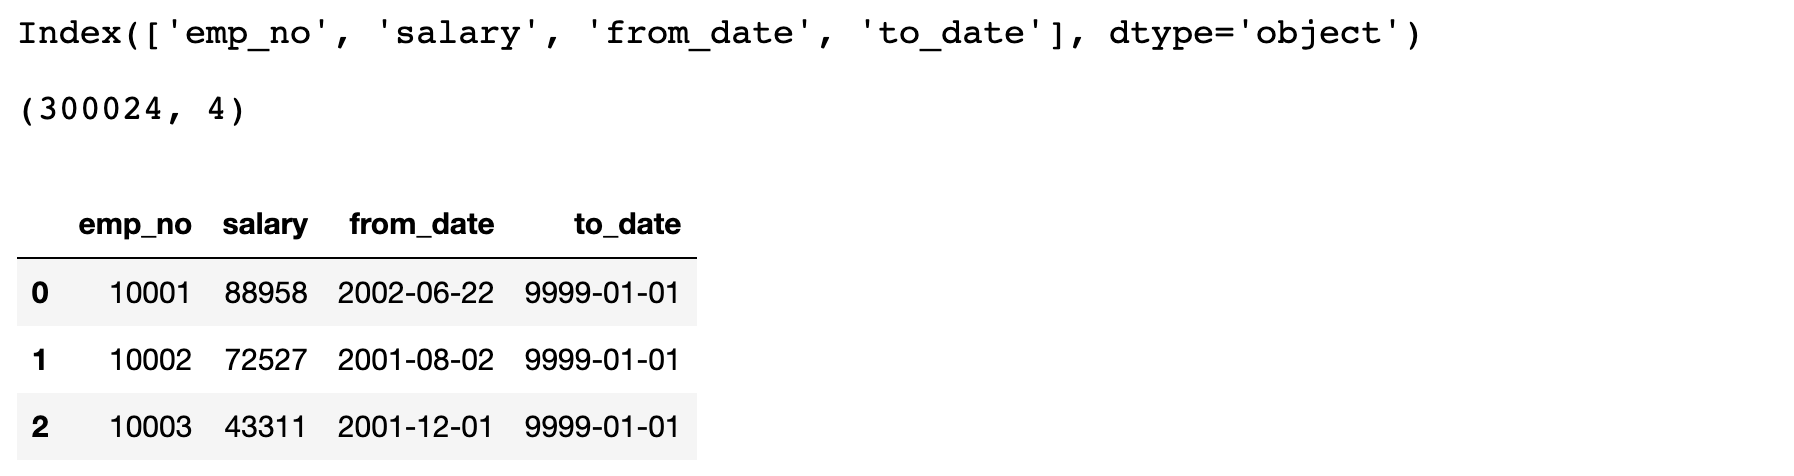

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [5]:
print(res['to_date'].dtype)

object


In [6]:
res["to_date"] = res["to_date"].astype(str).str.strip()
equal=(res["to_date"] == "9999-01-01").sum()
not_equal = len(res)-equal
print(f"Виходить що рівних 9999-01-01 = {equal} та навпаки не рівних = {not_equal}")

Виходить що рівних 9999-01-01 = 240124 та навпаки не рівних = 60056


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

In [7]:
from matplotlib import pyplot as plt 

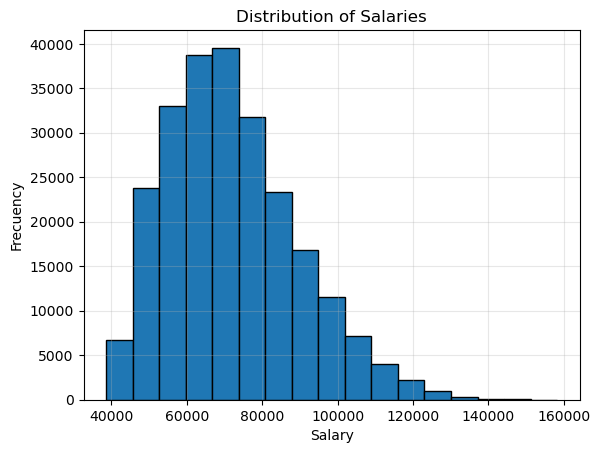

In [8]:
salaries = res[res["to_date"]== "9999-01-01"]["salary"]
plt.hist(salaries, bins=17, edgecolor='black')
plt.grid(axis='both', alpha=.3)
plt.xlabel("Salary")
plt.ylabel("Frecuency")
plt.title("Distribution of Salaries")
plt.show()

7.Виведіть кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишіть результат в змінну `df` та виведіть значення змінної на екран.

In [9]:
df = pd.read_sql(f"Select year(hire_date) as hire_year, count(*) as emp_num from employees group by hire_year", con)
display(df)

C:\Users\elena\AppData\Local\Temp\ipykernel_1152\1710101331.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"Select year(hire_date) as hire_year, count(*) as emp_num from employees group by hire_year", con)


,hire_year,emp_num
0,1986,36150
1,1985,35316
2,1989,28394
3,1994,14835
4,1990,25610
5,1992,20402
6,1987,33501
7,1995,12115
8,1993,17772
9,1999,1514


Очікуваний результат:

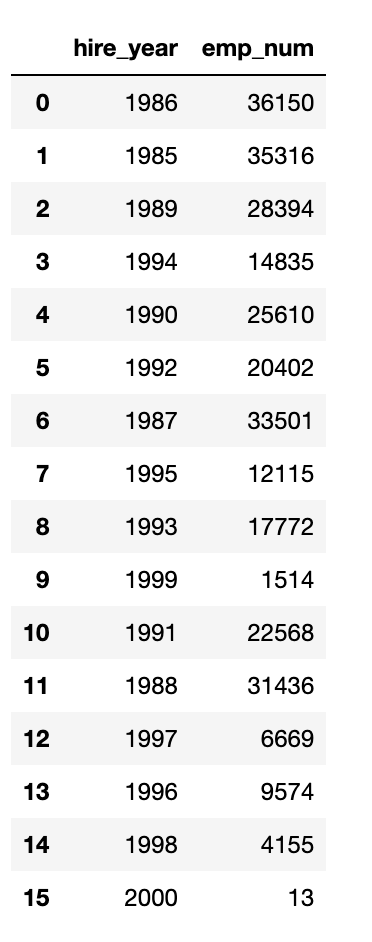

8.Виведіть лінійний графік залежності кількості найманих співробітників від року найму. Ми ж не просто так дані з бази дістали :)
Перейменувати назви колонок датафрейму можна або методами pandas, або в sql запиті в попередньому завданні. Також, аби графік вийшов правильний, треба відсортувати роки за зростанням. І це також можна зробити аби в pandas, або в SQL.

C:\Users\elena\AppData\Local\Temp\ipykernel_1152\3751450679.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  frequency_of_hiring = pd.read_sql(f"select year(hire_date) as hire_year, count(*) as emp_num from employees group by hire_year order by hire_year asc", con)


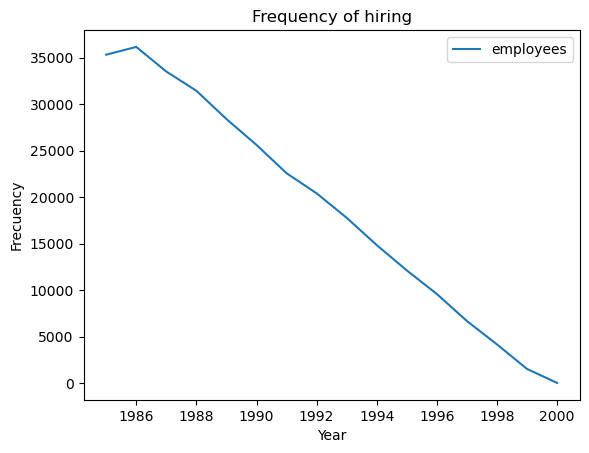

In [18]:
frequency_of_hiring = pd.read_sql(f"select year(hire_date) as hire_year, count(*) as emp_num from employees group by hire_year order by hire_year asc", con)
plt.plot(frequency_of_hiring["hire_year"], frequency_of_hiring["emp_num"],label="employees")
plt.title("Frequency of hiring")
plt.xlabel("Year")
plt.ylabel("Frecuency")
plt.legend()

Очікуваний результат:

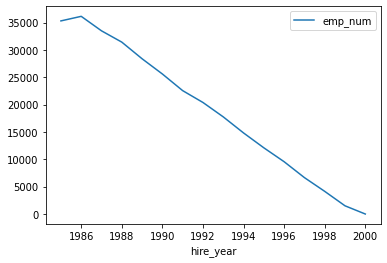

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії (тобто у них є значення to_date, яке заповнено НЕ значенням за замовчанням) знайдіть кількість повних років перебування на позиції. Позиція зберігається в колонці `title` в таблиці `titles`. Кількість років перебування на позиції можна отримати наприклад з використанням функції `timestampdiff`. Ознайомтесь з її використанням в [документації](https://dev.mysql.com/doc/refman/8.0/en/date-and-time-functions.html#function_timestampdiff).

Результат запишіть в змінну `df_years` та виведіть цю змінну на екран.

In [24]:
df_years = pd.read_sql("SELECT TIMESTAMPDIFF(YEAR, from_date, to_date) AS duration, from_date, to_date FROM titles WHERE title = 'Engineer' AND to_date != '9999-01-01'", con)
display(df_years)

C:\Users\elena\AppData\Local\Temp\ipykernel_1152\219075605.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_years = pd.read_sql("SELECT TIMESTAMPDIFF(YEAR, from_date, to_date) AS duration, from_date, to_date FROM titles WHERE title = 'Engineer' AND to_date != '9999-01-01'", con)


,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


Очікуваний результат:

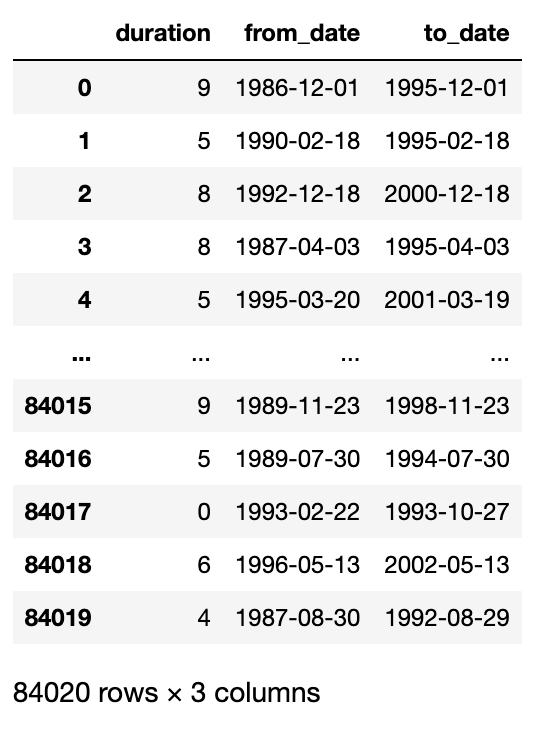

10.Використовуючи дані в  `df_years`, побудуйте гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції. Не забудьте дати назву діаграмі, а також підписати вісі.

Text(0, 0.5, 'Numer of employees')

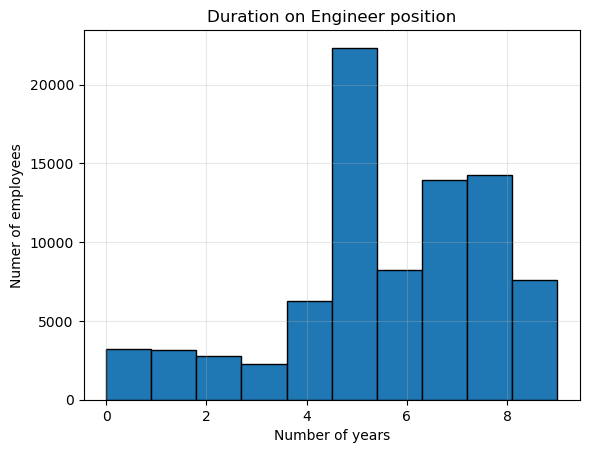

In [31]:
plt.hist(df_years["duration"], edgecolor= "black")
plt.grid(axis='both', alpha=.3)
plt.title("Duration on Engineer position")
plt.xlabel("Number of years")
plt.ylabel("Numer of employees")

Очікуваний результат:

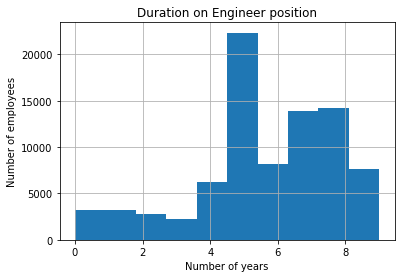

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [32]:
con.close()